- Temperaturdata hentet fra norsk klimaservicesenter [seklima.met.no](https://seklima.met.no/months/region_mean(air_temperature%20P1M%201961_1990),region_mean(air_temperature%20P1M%201991_2020)/all_years/GR0/nb/) (enhet: grader C)
- Elektrisitet hentet fra [ssb/14091](https://www.ssb.no/statbank/table/14091) (enhet: MWh)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import zscore
import statsmodels.api as sm
from datetime import timedelta, datetime

In [112]:
df1 = pd.read_csv("elektrisitet.csv", delimiter=";", na_values="..", encoding="latin1")
df1 = df1.pivot_table(index="måned", values="Elektrisk kraft", columns="produksjon og forbruk", aggfunc="first")
df1.reset_index(inplace=True)

df1["måned"] = pd.to_datetime(df1["måned"], format="%YM%m")

df1

produksjon og forbruk,måned,1 Total produksjon av elektrisk kraft,1.1 Produksjon av vannkraft,1.2 Produksjon av vindkraft,1.3 Produksjon av solkraft,1.4 Produksjon av varmekraft,2 Import,3 Eksport,4 Bruttoforbruk av elektrisk kraft,5 Pumpekraftforbruk,...,"7.231 Forbruk i produksjon av papirmasse, papir og papp",7.232 Forbruk i produksjon av kjemiske råvarer,"7.233 Forbruk i produksjon av jern, stål og ferro",7.234 Forbruk i produksjon av aluminium og andre metaller,7.24 Forbruk i industri utenom kraftintensiv industri,"7.25 Forbruk i kraftforsyning, VAR, bygg og anlegg",7.3 Forbruk i tertiærnæringer,7.4 Forbruk i husholdninger,7.41 Forbruk i boliger,7.42 Forbruk i hytter og fritidshus
0,1993-01-01,11718176.0,11673067.0,NaN,NaN,45109.0,42135.0,459820.0,11300491.0,90917.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-02-01,10675869.0,10636402.0,NaN,NaN,39467.0,35271.0,466053.0,10245087.0,91453.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-03-01,11406111.0,11377918.0,NaN,NaN,28193.0,35198.0,564604.0,10876705.0,89396.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-04-01,9464337.0,9426997.0,NaN,NaN,37340.0,40041.0,660249.0,8844129.0,91385.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-05-01,8339679.0,8292378.0,NaN,NaN,47301.0,25683.0,599141.0,7766221.0,206633.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,2024-10-01,12878212.0,11283463.0,1383865.0,7779.0,203105.0,1281038.0,2697042.0,11462208.0,83889.0,...,277228.0,558334.0,421039.0,1861821.0,678587.0,346229.0,2147978.0,3235406.0,3050830.0,184576.0
382,2024-11-01,14743252.0,13217189.0,1343629.0,2106.0,180328.0,1002181.0,3041763.0,12703670.0,61537.0,...,282813.0,484976.0,431714.0,1803382.0,684364.0,446571.0,2448669.0,4093880.0,3854840.0,239040.0
383,2024-12-01,15846494.0,13923035.0,1760253.0,715.0,162490.0,1103533.0,3150466.0,13799561.0,91119.0,...,276094.0,546544.0,386679.0,1844099.0,652509.0,515496.0,2655950.0,4750894.0,4445889.0,305005.0
384,2025-01-01,17367736.0,15778874.0,1414521.0,762.0,173579.0,849279.0,3464021.0,14752994.0,36192.0,...,278323.0,594150.0,405640.0,1866759.0,734784.0,572717.0,2829194.0,5215771.0,4889227.0,326544.0


In [113]:
df2 = pd.read_csv("temperatur.csv", delimiter=";", decimal=",", na_values="-")

df2.insert(3, "month", pd.to_datetime(df2["Tid(norsk normaltid)"], format="%m.%Y"))
df2.columns.values[4] = "Temperatur med normalperiode 1961-1990"
df2.columns.values[5] = "Temperatur med normalperiode 1991-2020"

df2

,Navn,Stasjon,Tid(norsk normaltid),month,Temperatur med normalperiode 1961-1990,Temperatur med normalperiode 1991-2020
0,Region Norge,GR0,12.1899,1899-12-01,-7.67,NaN
1,Region Norge,GR0,01.1900,1900-01-01,-7.17,NaN
2,Region Norge,GR0,02.1900,1900-02-01,-13.23,NaN
3,Region Norge,GR0,03.1900,1900-03-01,-5.60,NaN
4,Region Norge,GR0,04.1900,1900-04-01,-2.23,NaN
...,...,...,...,...,...,...
1499,Region Norge,GR0,11.2024,2024-11-01,NaN,-1.36
1500,Region Norge,GR0,12.2024,2024-12-01,NaN,-3.49
1501,Region Norge,GR0,01.2025,2025-01-01,NaN,-6.03
1502,Region Norge,GR0,02.2025,2025-02-01,NaN,-4.33


In [114]:
df = pd.merge(df1, df2, left_on="måned", right_on="month", how="inner")
df.insert(1, "month_idx", df["month"].dt.month)
df

,måned,month_idx,1 Total produksjon av elektrisk kraft,1.1 Produksjon av vannkraft,1.2 Produksjon av vindkraft,1.3 Produksjon av solkraft,1.4 Produksjon av varmekraft,2 Import,3 Eksport,4 Bruttoforbruk av elektrisk kraft,...,7.3 Forbruk i tertiærnæringer,7.4 Forbruk i husholdninger,7.41 Forbruk i boliger,7.42 Forbruk i hytter og fritidshus,Navn,Stasjon,Tid(norsk normaltid),month,Temperatur med normalperiode 1961-1990,Temperatur med normalperiode 1991-2020
0,1993-01-01,1,11718176.0,11673067.0,NaN,NaN,45109.0,42135.0,459820.0,11300491.0,...,NaN,NaN,NaN,NaN,Region Norge,GR0,01.1993,1993-01-01,-3.32,-4.48
1,1993-02-01,2,10675869.0,10636402.0,NaN,NaN,39467.0,35271.0,466053.0,10245087.0,...,NaN,NaN,NaN,NaN,Region Norge,GR0,02.1993,1993-02-01,-3.59,-4.44
2,1993-03-01,3,11406111.0,11377918.0,NaN,NaN,28193.0,35198.0,564604.0,10876705.0,...,NaN,NaN,NaN,NaN,Region Norge,GR0,03.1993,1993-03-01,-3.47,-4.20
3,1993-04-01,4,9464337.0,9426997.0,NaN,NaN,37340.0,40041.0,660249.0,8844129.0,...,NaN,NaN,NaN,NaN,Region Norge,GR0,04.1993,1993-04-01,0.15,-0.20
4,1993-05-01,5,8339679.0,8292378.0,NaN,NaN,47301.0,25683.0,599141.0,7766221.0,...,NaN,NaN,NaN,NaN,Region Norge,GR0,05.1993,1993-05-01,5.10,5.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,2024-10-01,10,12878212.0,11283463.0,1383865.0,7779.0,203105.0,1281038.0,2697042.0,11462208.0,...,2147978.0,3235406.0,3050830.0,184576.0,Region Norge,GR0,10.2024,2024-10-01,NaN,3.53
382,2024-11-01,11,14743252.0,13217189.0,1343629.0,2106.0,180328.0,1002181.0,3041763.0,12703670.0,...,2448669.0,4093880.0,3854840.0,239040.0,Region Norge,GR0,11.2024,2024-11-01,NaN,-1.36
383,2024-12-01,12,15846494.0,13923035.0,1760253.0,715.0,162490.0,1103533.0,3150466.0,13799561.0,...,2655950.0,4750894.0,4445889.0,305005.0,Region Norge,GR0,12.2024,2024-12-01,NaN,-3.49
384,2025-01-01,1,17367736.0,15778874.0,1414521.0,762.0,173579.0,849279.0,3464021.0,14752994.0,...,2829194.0,5215771.0,4889227.0,326544.0,Region Norge,GR0,01.2025,2025-01-01,NaN,-6.03


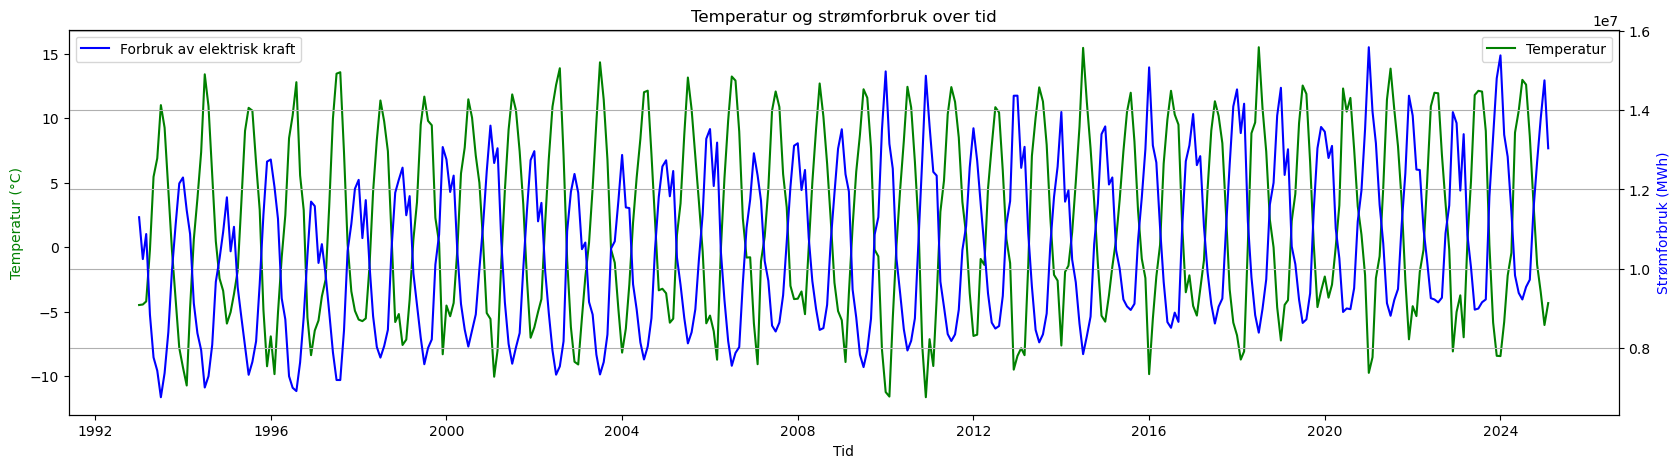

In [10]:
fix, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()

ax1.plot(df["month"], df["Temperatur med normalperiode 1991-2020"], "g-", label="Temperatur")
ax2.plot(df["month"], df["4 Bruttoforbruk av elektrisk kraft"], "b-", label="Forbruk av elektrisk kraft")

ax1.set_ylabel("Temperatur (°C)", color="g")
ax2.set_ylabel("Strømforbruk (MWh)", color="b")
ax1.set_xlabel("Tid")
plt.title("Temperatur og strømforbruk over tid")

ax1.legend()
ax2.legend()
plt.grid()

In [202]:
temp = df["Temperatur med normalperiode 1991-2020"]
s_temp = temp.std()
se_temp = s_temp / np.sqrt(len(temp))
s_temp, se_temp

(np.float64(6.993996494461379), np.float64(0.35598504860514785))

In [201]:
power = df["4 Bruttoforbruk av elektrisk kraft"]
s_power = power.std()
se_power = s_power / np.sqrt(len(power))
s_power, se_power

(np.float64(2004797.742914876), np.float64(102041.51839655799))

## Plotting av avvik

In [222]:
np.random.seed(42)

temperature = pd.Series(25 + 5 * np.sin(df.index / 10) + np.random.normal(0, 1, len(df)))
power_usage = pd.Series(100 + 20 * np.sin(df.index / 10) + np.random.normal(0, 5, len(df)))

rolling_window = 5
mean_temp = temp.rolling(rolling_window, center=True).mean()
se_temp = temp.rolling(rolling_window, center=True).std() / np.sqrt(rolling_window)

mean_power = power.rolling(rolling_window, center=True).mean()
se_power = power.rolling(rolling_window, center=True).std() / np.sqrt(rolling_window)

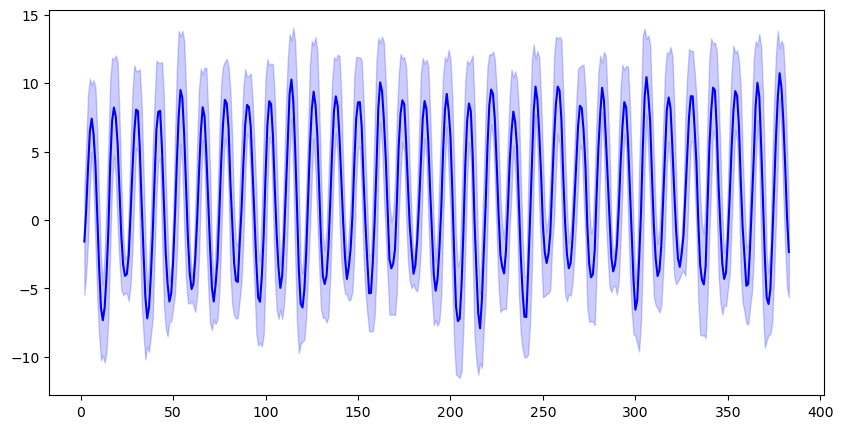

In [219]:
plt.figure(figsize=(10, 5))

plt.plot(df.index, mean_temp, label="Temperature", color="b")
plt.fill_between(df.index, mean_temp - 2 * se_temp, mean_temp + 2 * se_temp, color="b", alpha=0.2)

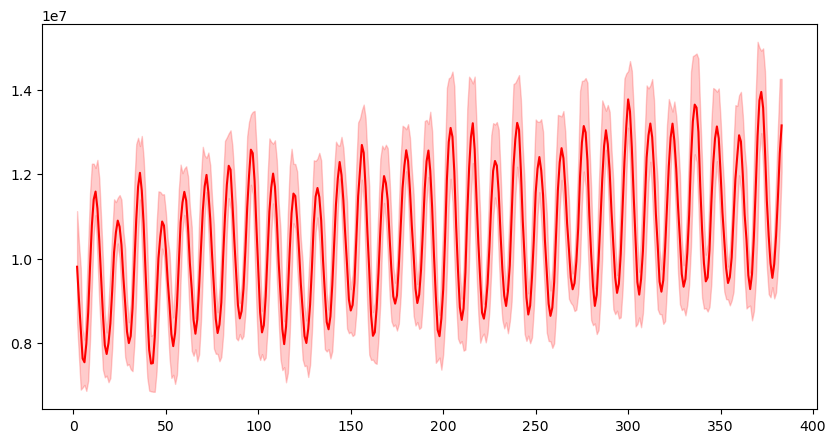

In [218]:
plt.figure(figsize=(10, 5))

plt.plot(df.index, mean_power, label="Power Usage", color="red")
plt.fill_between(df.index, mean_power - 2 * se_power, mean_power + 2 * se_power, color="red", alpha=0.2)

## Analyse av sammenheng

Ser at når temperaturen er lav, er strømforbruket mye høyere. Kan bruke pandas sin [`corr`](https://pandas.pydata.org/docs/reference/api/pandas.Series.corr.html)-funksjon for å sammenligne de to seriene med data.

Dette bruker [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), for å sjekke om det er en korrelasjon mellom de to ulike datasettene. Hvis verdien er nær $1$, betyr dette at det er en positiv sammenheng, og hvis verdien er nær $-1$, betyr det at det er en negativ sammenheng.

I dette tilfellet er det en negativ sammenheng, der lavere temperatur tilsvarer høyere strømforbruk.

In [15]:
df["Temperatur med normalperiode 1991-2020"].corr(df["4 Bruttoforbruk av elektrisk kraft"])

np.float64(-0.8946605079916043)

Plotter dette som punkter der $x$ er temperaturen og $y$ er strømforbruk.

Text(0.5, 1.0, 'Sammenheng mellom temperatur og strømforbruk')

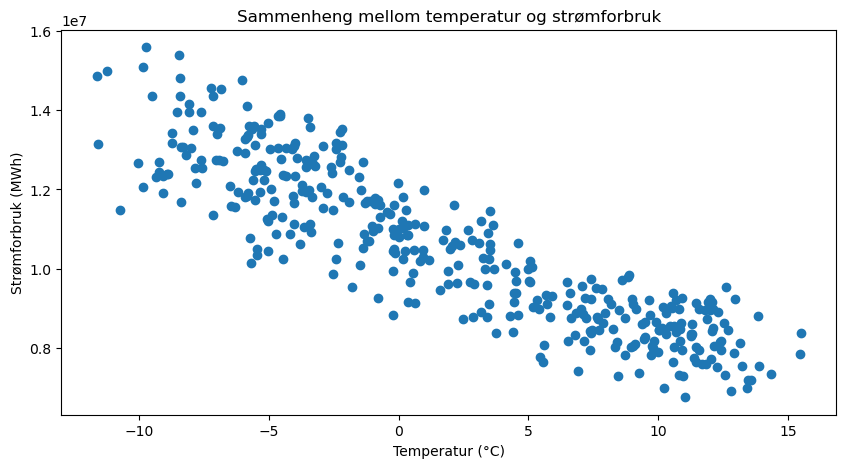

In [30]:
plt.figure(figsize=(10, 5))

plt.scatter(df["Temperatur med normalperiode 1991-2020"], df["4 Bruttoforbruk av elektrisk kraft"])
plt.xlabel("Temperatur (°C)")
plt.ylabel("Strømforbruk (MWh)")
plt.title("Sammenheng mellom temperatur og strømforbruk")

In [25]:
def model_linear(t, a, b):
    return a + b * t

In [28]:
coeffs_linear, _ = curve_fit(model_linear, df["Temperatur med normalperiode 1991-2020"], df["4 Bruttoforbruk av elektrisk kraft"])

In [33]:
xs_model = df["Temperatur med normalperiode 1991-2020"]
ys_model = model_linear(xs_model, *coeffs_linear)

Jeg utfører regresjonsanalyse på denne dataen, som ser veldig lineær ut. Ut fra dette kan jeg se ganske klart at nordmenn bruker mer elektrisitet ved lavere temperatur, og mindre elektrisitet når det er varmere.

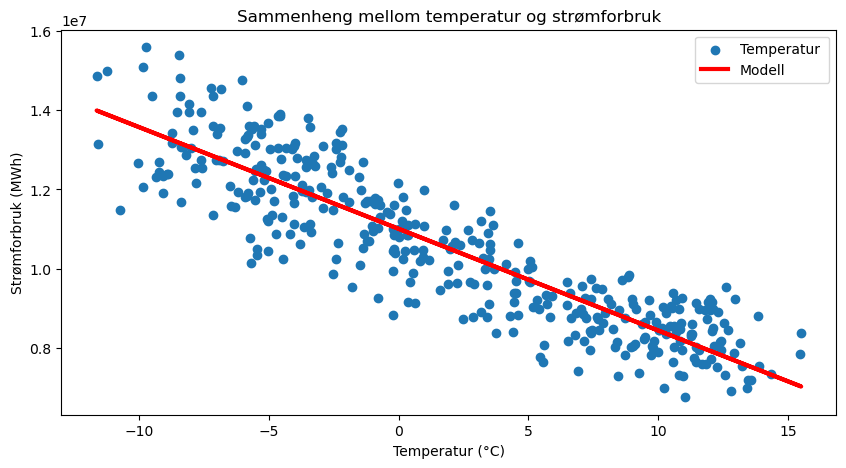

In [56]:
plt.figure(figsize=(10, 5))

plt.scatter(df["Temperatur med normalperiode 1991-2020"], df["4 Bruttoforbruk av elektrisk kraft"], label="Temperatur ")
plt.plot(xs_model, ys_model, "r-", linewidth=3, label="Modell")

plt.xlabel("Temperatur (°C)")
plt.ylabel("Strømforbruk (MWh)")
plt.title("Sammenheng mellom temperatur og strømforbruk")

plt.legend()

In [98]:
df_monthly = df.groupby("month_idx")
temp_monthly = df_monthly["Temperatur med normalperiode 1991-2020"].mean()
power_monthly = df_monthly["4 Bruttoforbruk av elektrisk kraft"].mean()

months = np.arange(1, 13)
month_names = ["Jan", "Feb", "Mar", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Des"]

Text(0.5, 1.0, 'Gjennomsnittlig temperatur og strømforbruk etter måned')

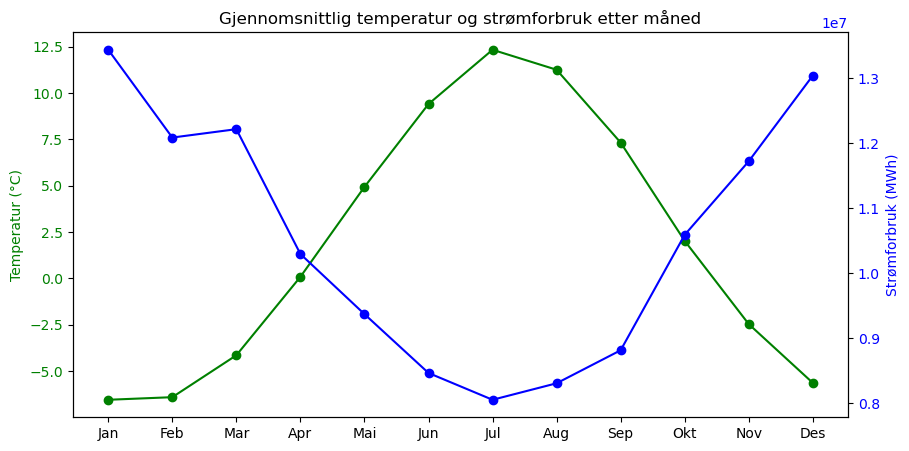

In [190]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(months, temp_monthly, color="g", label="Temperatur (°C)", marker="o")
ax1.set_ylabel("Temperatur (°C)", color="g")
ax1.tick_params(axis="y", labelcolor="g")

ax2 = ax1.twinx()
ax2.plot(months, power_monthly, color="b", label="Strømforbruk (MWh", marker="o")
ax2.set_ylabel("Strømforbruk (MWh)", color="b")
ax2.tick_params(axis="y", labelcolor="b")

ax1.set_xticks(months)
ax1.set_xticklabels(month_names)

ax1.set_title("Gjennomsnittlig temperatur og strømforbruk etter måned")

Text(0.5, 0, 'Tid')

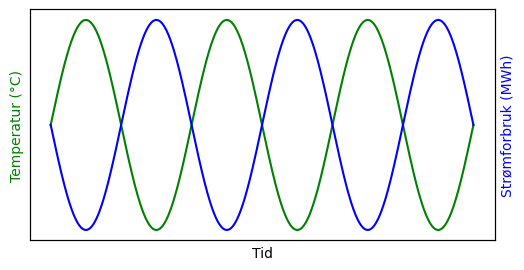

In [191]:
f = lambda x: np.sin(x)
g = lambda x: np.sin(x + np.pi)
xs = np.linspace(0, 6 * np.pi, 1000)

fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.plot(xs, f(xs), "g")
ax1.set_ylabel("Temperatur (°C)", color="g")

ax2 = plt.twinx()
ax2.plot(xs, g(xs), "b")
ax2.set_ylabel("Strømforbruk (MWh)", color="b")

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])

ax1.set_xlabel("Tid")

,### Bar-plot

Text(0.5, 1.0, 'Gjennomsnittlig temperatur og strømforbruk etter måned')

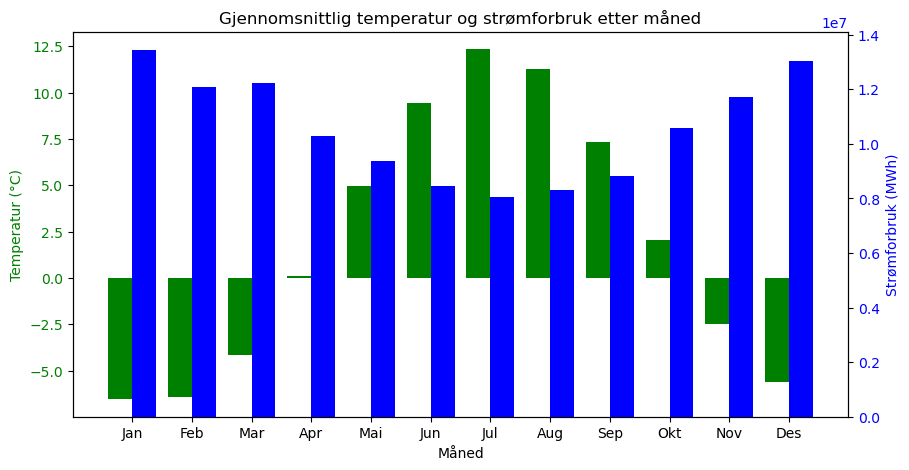

In [99]:
width = 0.4

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.bar(months - width / 2, temp_monthly, width=width, color="g", label="Temperatur (°C)")
ax1.set_ylabel("Temperatur (°C)", color="g")
ax1.tick_params(axis="y", labelcolor="g")

ax2.bar(months + width / 2, power_monthly, width=width, color="b", label="Strømforbruk (MWh)")
ax2.set_ylabel("Strømforbruk (MWh)", color="b")
ax2.tick_params(axis="y", labelcolor="b")

ax1.set_xlabel("Måned")
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(month_names)
plt.title("Gjennomsnittlig temperatur og strømforbruk etter måned")

### Heatmap

In [151]:
df2 = df.copy()
df2["year"] = df["month"].dt.year
df2["month"] = df["month"].dt.month

df_by_month = df2.groupby(["year", "month"]).agg({
    "Temperatur med normalperiode 1991-2020": "mean",
    "4 Bruttoforbruk av elektrisk kraft": "mean"
}).reset_index()

temp_pivot = df_by_month.pivot(index="year", columns="month", values="Temperatur med normalperiode 1991-2020")
power_pivot = df_by_month.pivot(index="year", columns="month", values="4 Bruttoforbruk av elektrisk kraft")

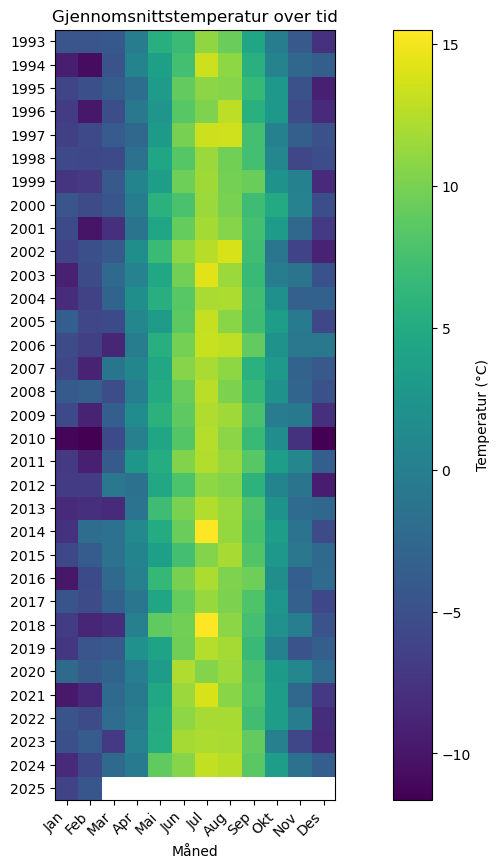

In [165]:
plt.figure(figsize=(15, 10))

plt.imshow(temp_pivot)
plt.colorbar(label="Temperatur (°C)")
plt.title("Gjennomsnittstemperatur over tid")

plt.xlabel("Måned")
plt.xticks(np.arange(0, 12), month_names, rotation=45, ha="right")
plt.yticks(np.arange(len(temp_pivot.index)), temp_pivot.index.astype(str))

plt.show()

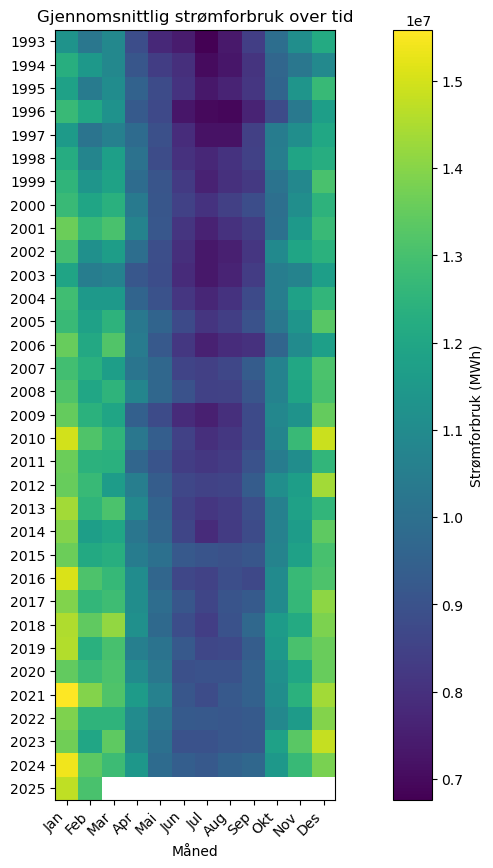

In [164]:
plt.figure(figsize=(15, 10))

plt.imshow(power_pivot)
plt.colorbar(label="Strømforbruk (MWh)")
plt.title("Gjennomsnittlig strømforbruk over tid")

plt.xlabel("Måned")
plt.xticks(np.arange(0, 12), month_names, rotation=45, ha="right")
plt.yticks(np.arange(len(temp_pivot.index)), temp_pivot.index.astype(str))

plt.show()


## (Forsøk på å plotte forholdet)

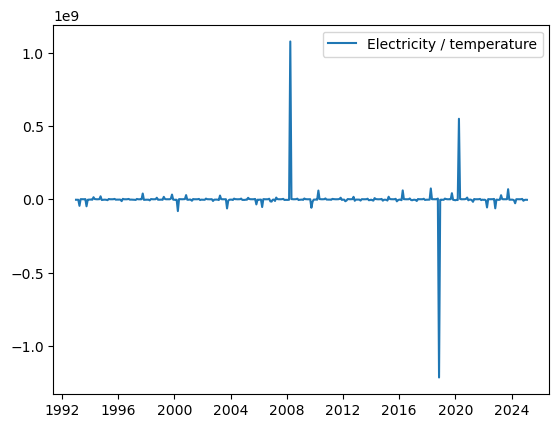

In [23]:
df["electricity_temp_factor"] =  df["4 Bruttoforbruk av elektrisk kraft"] / df["Temperatur med normalperiode 1991-2020"]
plt.plot(df["month"], df["electricity_temp_factor"], label="Electricity / temperature")

plt.legend()

Det er tre avvik i grafen. Når jeg sjekker hva dette er, ser jeg at det er fordi temperaturen er veldig nærme 0, og da vil også nevneren være nær 0, slik at det skaper store avvik i dataen.

In [78]:
outliers = df[df["electricity_temp_factor"].abs() > 0.3e9]
outliers

,måned,month_number,1 Total produksjon av elektrisk kraft,1.1 Produksjon av vannkraft,1.2 Produksjon av vindkraft,1.3 Produksjon av solkraft,1.4 Produksjon av varmekraft,2 Import,3 Eksport,4 Bruttoforbruk av elektrisk kraft,...,7.4 Forbruk i husholdninger,7.41 Forbruk i boliger,7.42 Forbruk i hytter og fritidshus,Navn,Stasjon,Tid(norsk normaltid),month,Temperatur med normalperiode 1961-1990,Temperatur med normalperiode 1991-2020,electricity_temp_factor
183,2008-04-01,183,11300049.0,11137187.0,53297.0,NaN,109565.0,412675.0,923090.0,10789634.0,...,NaN,NaN,NaN,Region Norge,GR0,04.2008,2008-04-01,0.29,0.01,1.078963e+09
310,2018-11-01,310,13665597.0,12932163.0,447944.0,NaN,285490.0,444289.0,1940219.0,12169667.0,...,NaN,NaN,NaN,Region Norge,GR0,11.2018,2018-11-01,0.65,-0.01,-1.216967e+09
327,2020-04-01,327,12588652.0,11616762.0,686210.0,2905.0,282776.0,401557.0,1974639.0,11015570.0,...,3564918.0,3364278.0,200641.0,Region Norge,GR0,04.2020,2020-04-01,0.41,0.02,5.507785e+08


Plotter dataen men ekskluderer disse avvikene:

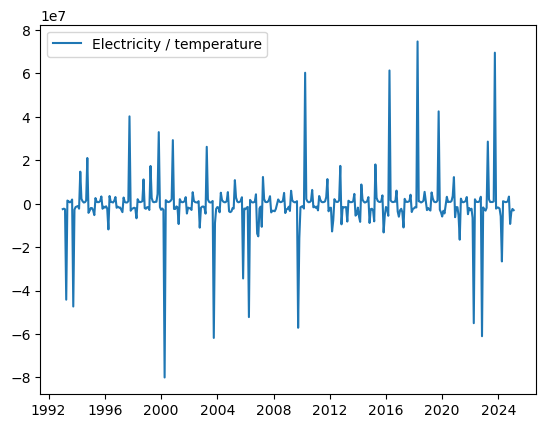

In [81]:
_df = df[df["electricity_temp_factor"].abs() < 0.3e9]
plt.plot(_df["month"], _df["electricity_temp_factor"], label="Electricity / temperature")

plt.legend()